## Predicting winners among undervalued public firms based on fundamental data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### Exec Summary

    Leveraging the UChicago research for determining various performance metrics using 
    the fundamental data, I perform analysis to try to understand the association between 
    the performance metrics and the subsequent success of the firm.

    I begin with an exploratory analysis to get a feel for the data. Thereafter, using 
    various machine learning models, I also attempt to predict whether a stock will be
    a winner based on the same metrics. Models are scored across various metrics, 
    including accuracy, precision, recall, f1 score, and the ROC curve.


### Problem Statement

    Based on the publicly available financial accounting information, we want to identify winners and losers among undervalued (i.e., firms with higher book value than market value) public firms. We will use the fundamental dataset available on kaggle to calculate metrics based on a research done by UChicago on value investing. The fundamental dataset covers financial data on 400+ firms over a 4 year period between 2012 and 2015. Further, we will build a model to determine whether the metrics can predict winners and losers among undervalued firms. 

### Source

- Metrics from fundamental data is based on UChicago reasearch paper on value investing - "The Use of Historical Financial Statement Information
to Separate Winners from Losers - Joseph D. Piotroski" (https://www.chicagobooth.edu/~/media/FE874EE65F624AAEBD0166B1974FD74D.pdf)
- Fundamental data from kaggle (https://www.kaggle.com/dgawlik/nyse)

### Dataset Description

#### Fundamental data

Variable |Type of Variable |Description
:- |:- |:-
Id|numeric|line id
Ticker Symbol|text|publicly traded symbol name
Period Ending|text|financial year ending date
Accounts Payable|numeric|
Accounts Receivable|numeric|
Add'l income/expense items|numeric|
After Tax ROE|numeric|
Capital Expenditures|numeric|
Capital Surplus|numeric|
Cash Ratio|numeric|
Cash and Cash Equivalents|numeric|
Changes in Inventories|numeric|
Common Stocks|numeric|
Cost of Revenue|numeric|
Current Ratio|numeric|
Deferred Asset Charges|numeric|
Deferred Liability Charges|numeric|
Depreciation|numeric|
Earnings Before Interest and Tax|numeric|
Earnings Before Tax|numeric|
Effect of Exchange Rate|numeric|
Equity Earnings/Loss Unconsolidated Subsidiary|numeric|
Fixed Assets|numeric|
Goodwill|numeric|
Gross Margin|numeric|
Gross Profit|numeric|
Income Tax|numeric|
Intangible Assets|numeric|
Interest Expense|numeric|
Inventory|numeric|
Investments|numeric|
Liabilities|numeric|
Long-Term Debt|numeric|
Long-Term Investments|numeric|
Minority Interest|numeric|
Misc. Stocks|numeric|
Net Borrowings|numeric|
Net Cash Flow|numeric|
Net Cash Flow-Operating|numeric|
Net Cash Flows-Financing|numeric|
Net Cash Flows-Investing|numeric|
Net Income|numeric|
Net Income Adjustments|numeric|
Net Income Applicable to Common Shareholders|numeric|
Net Income-Cont. Operations|numeric|
Net Receivables|numeric|
Non-Recurring Items|numeric|
Operating Income|numeric|
Operating Margin|numeric|
Other Assets|numeric|
Other Current Assets|numeric|
Other Current Liabilities|numeric|
Other Equity|numeric|
Other Financing Activities|numeric|
Other Investing Activities|numeric|
Other Liabilities|numeric|
Other Operating Activities|numeric|
Other Operating Items|numeric|
Pre-Tax Margin|numeric|
Pre-Tax ROE|numeric|
Profit Margin|numeric|
Quick Ratio|numeric|accounting ratio
Research and Development|numeric|
Retained Earnings|numeric|
Sale and Purchase of Stock|numeric|
"Sales General and Admin."|numeric|
Short-Term Debt / Current Portion of Long-Term Debt|numeric|
Short-Term Investments|numeric|
Total Assets|numeric|
Total Current Assets|numeric|
Total Current Liabilities|numeric|
Total Equity|numeric|
Total Liabilities|numeric|
Total Liabilities & Equity|numeric|
Total Revenue|numeric|
Treasury Stock|numeric|
For Year|numeric|
Earnings Per Share|numeric|
Estimated Shares Outstanding|numeric|


#### Prices data

Variable|Type of Variable|Description
:- |:- |:-
date|text|trading date
symbol|text|symbol traded
open|numeric|opening price
close|numeric|closing price
low|numeric|low price of the day
high|numeric|high price of the day
volume|numeric|traded volume

#### Securities data

Variable|Type of Variable|Description
:-|:-|:-
"Ticker symbol"|text|traded symbol
"Security"|text|company name
"SEC filings"|text|filing type
"GICS Sector"|text|sector that the company belongs
"GICS Sub Industry"|text|sub industry category
"Address of Headquarters"|text|address
"Date first added"|text|issued date
"CIK"|text|central index key


### Risks and Assumptions

    - Data contains accurate information
    - Minimum 2 years of information is needed to calculate metrics
    - There exists inefficiency with market pricing of undervalued firms
    - Data may not correctly reflect corporate action information
    - Dataset may not be sufficient
    - Dataset for a particular sector/industry may not be sufficient

### Success Metrics

    - Able to clean, munge, combine different data sets, and identify undervalued firms
    - Classify winners/losers based on FSCORE metrics and show whether there is meaningful association or not

### Hypothesis

Null Hypothesis: 
       
    There is no association between future win/loss of undervalued firms and FSCORE metrics obtained from financial accounting data
    
Alternate Hypothesis:

    FSCORE metrics from financial accounting data can help predict future win/loss of undervalued firms

### Exploratory Analysis

In [2]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [8,5]

#### Load fundamental data

In [3]:
df_fundamentals=pd.read_csv("../data/fundamentals.csv")
df_fundamentals.head()

,Id,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [4]:
df_fundamentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 79 columns):
Id                                                     1781 non-null int64
Ticker Symbol                                          1781 non-null object
Period Ending                                          1781 non-null object
Accounts Payable                                       1781 non-null float64
Accounts Receivable                                    1781 non-null float64
Add'l income/expense items                             1781 non-null float64
After Tax ROE                                          1781 non-null float64
Capital Expenditures                                   1781 non-null float64
Capital Surplus                                        1781 non-null float64
Cash Ratio                                             1482 non-null float64
Cash and Cash Equivalents                              1781 non-null float64
Changes in Inventories                            

##### Create date index using period ending

In [5]:
df_fundamentals.columns = [c.replace(' ', '_') for c in df_fundamentals.columns]
df_fundamentals['Period_Ending'] = pd.to_datetime(df_fundamentals['Period_Ending'])
df_fundamentals.set_index('Period_Ending', inplace=True)

In [6]:
df_fundamentals.head()

,Id,Ticker_Symbol,Accounts_Payable,Accounts_Receivable,Add'l_income/expense_items,After_Tax_ROE,Capital_Expenditures,Capital_Surplus,Cash_Ratio,Cash_and_Cash_Equivalents,...,Total_Current_Assets,Total_Current_Liabilities,Total_Equity,Total_Liabilities,Total_Liabilities_&_Equity,Total_Revenue,Treasury_Stock,For_Year,Earnings_Per_Share,Estimated_Shares_Outstanding
Period_Ending,,,,,,,,,,,,,,,,,,,,,
2012-12-31,0,AAL,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
2013-12-31,1,AAL,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2014-12-31,2,AAL,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
2015-12-31,3,AAL,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
2012-12-29,4,AAP,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


### Calculation of Factors from fundamental data

In [7]:
import math

# gets a zero or one score based on whether the value of the data. Also, takes in whether the logic needs to
# be inverted
def getScore(val, inverse=False):
    if math.isnan(val): return np.nan

    if val > 0:
        if not inverse: return 1
        else: return 0
    else:
        if not inverse: return 0
        else: return 1

#### Peformance related factors - Profitability
    
    Current profitability and cash flow realizations provide information about the firm’s ability to generate 
    funds internally. A positive earnings trend is suggestive of an improvement in the firm’s underlying 
    ability to generate positive future cash flows.
    
    * Return of Assets(ROA) => Net income scaled by start of year assets
    * Cash from Operations(CFO) => Cash from operations scaled by start of year assets
    * Delta ROA => Current year's ROA - Previous year's ROA
    * Accrual => Net income - cash flow from operations scaled by start of year assets

In [8]:
# Adding Book Value column, as the Total_Equity values on the original data seems unreliable. 
df_fundamentals['BookValue'] = df_fundamentals['Total_Assets'] - df_fundamentals['Total_Liabilities']

# Create Total Assets at the beginning of the year by taking the end of previous year total assets
df_fundamentals['Begin_Total_Assets'] = df_fundamentals.groupby('Ticker_Symbol')['Total_Assets'].apply(lambda x: x.shift(1))

# Return on Assets (Net income scaled by assets at the beginning of the year)
df_fundamentals['ROA'] = df_fundamentals['Net_Income'] / df_fundamentals['Begin_Total_Assets']

#calculate the score based on ROA
df_fundamentals['F_ROA'] = df_fundamentals['ROA'].apply(lambda x: getScore(x))

# Cash from operations (Cash from operations scaled by assets at the beginning of the year)
df_fundamentals['CFO'] = df_fundamentals['Net_Cash_Flow-Operating'] / df_fundamentals['Begin_Total_Assets']

#calculate the score based on CFO
df_fundamentals['F_CFO'] = df_fundamentals['CFO'].apply(lambda x: getScore(x))

# Delta ROA
df_fundamentals['Begin_ROA'] = df_fundamentals.groupby('Ticker_Symbol')['ROA'].apply(lambda x: x.shift(1))

df_fundamentals['Delta_ROA'] = df_fundamentals['ROA'] - df_fundamentals['Begin_ROA']

#calculate the score based on Delta ROA
df_fundamentals['F_Delta_ROA'] = df_fundamentals['Delta_ROA'].apply(lambda x: getScore(x))

# Accrual
df_fundamentals['Accrual'] = (df_fundamentals['Net_Income'] - df_fundamentals['Net_Cash_Flow-Operating'])/df_fundamentals['Begin_Total_Assets']

#calculate the score based on Accural
df_fundamentals['F_Accrual'] = df_fundamentals['Accrual'].apply(lambda x: getScore(x))

df_fundamentals[['Ticker_Symbol', 'BookValue', 'ROA', 'F_ROA', 'CFO', 'F_CFO', 'F_ROA', 'F_Accrual']].head()
                                                                   

,Ticker_Symbol,BookValue,ROA,F_ROA,CFO,F_CFO,F_ROA,F_Accrual
Period_Ending,,,,,,,,
2012-12-31,AAL,-1.381000e+09,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,AAL,-2.731000e+09,-0.078009,0.0,0.028711,1.0,0.0,0.0
2014-12-31,AAL,2.021000e+09,0.068168,1.0,0.072851,1.0,1.0,0.0
2015-12-31,AAL,5.635000e+09,0.176056,1.0,0.144569,1.0,1.0,1.0
2012-12-29,AAP,1.210694e+09,NaN,NaN,NaN,NaN,NaN,NaN


#### Performance related factors - measure changes in capital structure and the firm’s ability to meet future debt service obligations

    Since most high BM firms are financially constrained, an increase in leverage, a deterioration of liquidity, 
    or the use of external financing can provide signal about financial risk.
    
    * Delta Leverage => Change in Ratio of total long-term debt to average total assets
    * Delta Liquidity => Change in current ratio (current assets/current liabilities) in comparison to previous year
    * Source of Funds => Was equity issued in the prior year


In [9]:

df_fundamentals['Average_Total_Assets'] = (df_fundamentals['Total_Assets'] + df_fundamentals['Begin_Total_Assets'])/2.0
df_fundamentals['Total_Debt'] = df_fundamentals['Long-Term_Debt'] + df_fundamentals['Short-Term_Debt_/_Current_Portion_of_Long-Term_Debt']
df_fundamentals['Leverage'] = df_fundamentals['Total_Debt']/df_fundamentals['Average_Total_Assets']

# To calculate change in leverage
df_fundamentals['Begin_Leverage'] = df_fundamentals.groupby('Ticker_Symbol')['Leverage'].apply(lambda x: x.shift(1))
df_fundamentals['Delta_Leverage'] = df_fundamentals['Leverage'] - df_fundamentals['Begin_Leverage']

#calculate the score based on change in leverage
df_fundamentals['F_Leverage'] = df_fundamentals['Delta_Leverage'].apply(lambda x: getScore(x, True))

# To calculate change in liquidity
df_fundamentals['Begin_Liquidity'] = df_fundamentals.groupby('Ticker_Symbol')['Current_Ratio'].apply(lambda x: x.shift(1))
df_fundamentals['Delta_Liquidity'] = df_fundamentals['Current_Ratio'] - df_fundamentals['Begin_Liquidity']

#calculate the score based on change in leverage
df_fundamentals['F_Liquidity'] = df_fundamentals['Delta_Liquidity'].apply(lambda x: getScore(x))

# Did the firm issue additional equity
df_fundamentals['Begin_Common_Stocks'] = df_fundamentals.groupby('Ticker_Symbol')['Common_Stocks'].apply(lambda x: x.shift(1))
df_fundamentals['Delta_Eq_Offer'] = df_fundamentals['Common_Stocks'] - df_fundamentals['Begin_Common_Stocks']

#calculate the score based on shares issued
df_fundamentals['F_Eq_Offer'] = df_fundamentals['Delta_Eq_Offer'].apply(lambda x: getScore(x, True))


df_fundamentals[['Ticker_Symbol', 'Total_Liabilities', 'Long-Term_Debt', 'Total_Debt', 'F_Leverage', 'F_Liquidity', 
                 'F_Eq_Offer']].head()
                                                                   

,Ticker_Symbol,Total_Liabilities,Long-Term_Debt,Total_Debt,F_Leverage,F_Liquidity,F_Eq_Offer
Period_Ending,,,,,,,
2012-12-31,AAL,2.489100e+10,7.116000e+09,8.535000e+09,NaN,NaN,NaN
2013-12-31,AAL,4.500900e+10,1.535300e+10,1.679900e+10,NaN,1.0,1.0
2014-12-31,AAL,4.120400e+10,1.604300e+10,1.772000e+10,1.0,0.0,0.0
2015-12-31,AAL,4.278000e+10,1.833000e+10,2.056100e+10,0.0,0.0,1.0
2012-12-29,AAP,3.403120e+09,6.044610e+08,6.050880e+08,NaN,NaN,NaN


#### Performance related factors - measures changes in efficiency of operations

    Since most high BM firms are financially constrained, an increase in leverage, a deterioration of liquidity, 
    or the use of external financing can provide signal about financial risk.
    
    * Delta Margin - Change in gross margin scaled by total sales
    * Delta Turnover - Change in current ratio (current assets/current liabilities) in comparison to previous year

In [10]:
# To calculate change in margin
df_fundamentals['Margin_Ratio'] = df_fundamentals['Gross_Margin'] / df_fundamentals['Total_Revenue']
df_fundamentals['Begin_Margin_Ratio'] = df_fundamentals.groupby('Ticker_Symbol')['Margin_Ratio'].apply(lambda x: x.shift(1))
df_fundamentals['Delta_Margin'] = df_fundamentals['Margin_Ratio'] - df_fundamentals['Begin_Margin_Ratio']

#calculate the score based on change in margin ratio
df_fundamentals['F_Delta_Margin'] = df_fundamentals['Delta_Margin'].apply(lambda x: getScore(x))

# To calculate change in turnover
df_fundamentals['Turnover_Ratio'] = df_fundamentals['Total_Revenue'] / df_fundamentals['Begin_Total_Assets']
df_fundamentals['Begin_Turnover_Ratio'] = df_fundamentals.groupby('Ticker_Symbol')['Turnover_Ratio'].apply(lambda x: x.shift(1))
df_fundamentals['Delta_Turnover'] = df_fundamentals['Turnover_Ratio'] - df_fundamentals['Begin_Turnover_Ratio']

#calculate the score based on change in turnover
df_fundamentals['F_Delta_Turnover'] = df_fundamentals['Delta_Turnover'].apply(lambda x: getScore(x))

df_fundamentals[['Ticker_Symbol', 'F_Delta_Margin', 'F_Delta_Turnover', 'F_Leverage', 'F_Liquidity', 
                 'F_Eq_Offer']].head()
                                 

,Ticker_Symbol,F_Delta_Margin,F_Delta_Turnover,F_Leverage,F_Liquidity,F_Eq_Offer
Period_Ending,,,,,,
2012-12-31,AAL,NaN,NaN,NaN,NaN,NaN
2013-12-31,AAL,0.0,NaN,NaN,1.0,1.0
2014-12-31,AAL,0.0,0.0,1.0,0.0,0.0
2015-12-31,AAL,1.0,0.0,0.0,0.0,1.0
2012-12-29,AAP,NaN,NaN,NaN,NaN,NaN


#### Load prices data

In [11]:
df_prices=pd.read_csv("../data/prices.csv")
df_prices['date'] = pd.to_datetime(df_prices['date'])
df_prices_dec = df_prices[df_prices['date'].dt.month == 12]
df_prices_last_day = df_prices_dec.groupby(['symbol', df_prices_dec.date.dt.year]).nth(-1)
df_prices_last_day.index.names=['symbol', 'year']
df_prices_last_day.reset_index(inplace=True)

In [12]:
display(df_prices_last_day.info())
display(df_prices_last_day.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 8 columns):
symbol    3390 non-null object
year      3390 non-null int64
close     3390 non-null float64
date      3390 non-null datetime64[ns]
high      3390 non-null float64
low       3390 non-null float64
open      3390 non-null float64
volume    3390 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 211.9+ KB


None

,symbol,year,close,date,high,low,open,volume
0,A,2010,41.430000,2010-12-31,41.699999,41.240000,41.430000,2050700.0
1,A,2011,34.929999,2011-12-30,35.509999,34.819999,34.929999,1930900.0
2,A,2012,40.940001,2012-12-31,40.970001,39.639999,39.690000,4707900.0
3,A,2013,57.189999,2013-12-31,57.549999,57.080001,57.450001,1316000.0
4,A,2014,40.939999,2014-12-31,41.790001,40.900002,41.389999,1421100.0


In [13]:
# simple function to look up prices for a given date - assumes the df passed contains prices for the last
# available day of the year
def getClosePrice(ref_df, symbol, date):
    df = ref_df[(ref_df['symbol'] == symbol) & (ref_df['year'] == date.year)]
    if df.empty:
        return np.nan
    else:
        return float(df['close'])

### Simpler view of the data with columns of interest

In [14]:
df_clean = df_fundamentals[['Ticker_Symbol', 'BookValue', 'Estimated_Shares_Outstanding'
                            , 'ROA', 'F_ROA'
                            , 'CFO', 'F_CFO'
                            , 'Delta_ROA', 'F_Delta_ROA'
                            , 'Accrual', 'F_Accrual'
                            , 'Delta_Margin', 'F_Delta_Margin'
                            , 'Delta_Turnover', 'F_Delta_Turnover'
                            , 'Delta_Leverage', 'F_Leverage'
                            , 'Delta_Liquidity', 'F_Liquidity' 
                            , 'Delta_Eq_Offer', 'F_Eq_Offer'
                            , 'For_Year'
                           ]]

# metric defined by the research is a summation of the individual scores
df_clean['F_SCORE'] = df_clean.apply(lambda row: 
                                     (
                                        row['F_ROA']
                                         + row['F_CFO'] 
                                         + row['F_Delta_ROA']
                                         + row['F_Accrual']
                                         + row['F_Delta_Margin']
                                         + row['F_Delta_Turnover']
                                         + row['F_Leverage']
                                         + row['F_Liquidity']
                                         + row['F_Eq_Offer']
                                      )
                                    , axis=1)
df_clean.head(5)

/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Ticker_Symbol,BookValue,Estimated_Shares_Outstanding,ROA,F_ROA,CFO,F_CFO,Delta_ROA,F_Delta_ROA,Accrual,...,Delta_Turnover,F_Delta_Turnover,Delta_Leverage,F_Leverage,Delta_Liquidity,F_Liquidity,Delta_Eq_Offer,F_Eq_Offer,For_Year,F_SCORE
Period_Ending,,,,,,,,,,,,,,,,,,,,,
2012-12-31,AAL,-1.381000e+09,3.350000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,NaN
2013-12-31,AAL,-2.731000e+09,1.630222e+08,-0.078009,0.0,0.028711,1.0,NaN,NaN,-0.106721,...,NaN,NaN,NaN,NaN,26.0,1.0,-122000000.0,1.0,2013.0,NaN
2014-12-31,AAL,2.021000e+09,7.169154e+08,0.068168,1.0,0.072851,1.0,0.146177,1.0,-0.004683,...,-0.128717,0.0,-0.096213,1.0,-16.0,0.0,2000000.0,0.0,2014.0,4.0
2015-12-31,AAL,5.635000e+09,6.681299e+08,0.176056,1.0,0.144569,1.0,0.107888,1.0,0.031486,...,-0.060505,0.0,0.034246,0.0,-15.0,0.0,-1000000.0,1.0,2015.0,6.0
2012-12-29,AAP,1.210694e+09,7.328355e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,NaN


#### Get prices into the dataset

In [15]:
# pull close prices for the current year and the previous year
close = []
last_year_close = []
for symbol, date in zip(df_clean['Ticker_Symbol'], df_clean.index):
    c = getClosePrice(df_prices_last_day, symbol, date)
    p = getClosePrice(df_prices_last_day, symbol, (date-pd.DateOffset(years=1)))
    close.append(c)
    last_year_close.append(p)

df_clean['Close_Price'] = close
df_clean['Last_Year_Close_Price'] = last_year_close
df_clean.head(5)

/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Ticker_Symbol,BookValue,Estimated_Shares_Outstanding,ROA,F_ROA,CFO,F_CFO,Delta_ROA,F_Delta_ROA,Accrual,...,Delta_Leverage,F_Leverage,Delta_Liquidity,F_Liquidity,Delta_Eq_Offer,F_Eq_Offer,For_Year,F_SCORE,Close_Price,Last_Year_Close_Price
Period_Ending,,,,,,,,,,,,,,,,,,,,,
2012-12-31,AAL,-1.381000e+09,3.350000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,NaN,13.500000,5.070000
2013-12-31,AAL,-2.731000e+09,1.630222e+08,-0.078009,0.0,0.028711,1.0,NaN,NaN,-0.106721,...,NaN,NaN,26.0,1.0,-122000000.0,1.0,2013.0,NaN,25.250000,13.500000
2014-12-31,AAL,2.021000e+09,7.169154e+08,0.068168,1.0,0.072851,1.0,0.146177,1.0,-0.004683,...,-0.096213,1.0,-16.0,0.0,2000000.0,0.0,2014.0,4.0,53.630001,25.250000
2015-12-31,AAL,5.635000e+09,6.681299e+08,0.176056,1.0,0.144569,1.0,0.107888,1.0,0.031486,...,0.034246,0.0,-15.0,0.0,-1000000.0,1.0,2015.0,6.0,42.349998,53.630001
2012-12-29,AAP,1.210694e+09,7.328355e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,NaN,72.349998,69.629997


#### Calculate Market value based on the prices we have loaded

In [16]:
df_clean['Market_Value'] = df_clean.apply(lambda row: row['Estimated_Shares_Outstanding'] * row['Close_Price']
                                          , axis=1)
df_clean['Book_To_Market'] = df_clean.apply(lambda row: row['BookValue'] / row['Market_Value']
                                          , axis=1)
df_clean.head(5)

/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Ticker_Symbol,BookValue,Estimated_Shares_Outstanding,ROA,F_ROA,CFO,F_CFO,Delta_ROA,F_Delta_ROA,Accrual,...,Delta_Liquidity,F_Liquidity,Delta_Eq_Offer,F_Eq_Offer,For_Year,F_SCORE,Close_Price,Last_Year_Close_Price,Market_Value,Book_To_Market
Period_Ending,,,,,,,,,,,,,,,,,,,,,
2012-12-31,AAL,-1.381000e+09,3.350000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2012.0,NaN,13.500000,5.070000,4.522500e+09,-0.305362
2013-12-31,AAL,-2.731000e+09,1.630222e+08,-0.078009,0.0,0.028711,1.0,NaN,NaN,-0.106721,...,26.0,1.0,-122000000.0,1.0,2013.0,NaN,25.250000,13.500000,4.116311e+09,-0.663458
2014-12-31,AAL,2.021000e+09,7.169154e+08,0.068168,1.0,0.072851,1.0,0.146177,1.0,-0.004683,...,-16.0,0.0,2000000.0,0.0,2014.0,4.0,53.630001,25.250000,3.844817e+10,0.052564
2015-12-31,AAL,5.635000e+09,6.681299e+08,0.176056,1.0,0.144569,1.0,0.107888,1.0,0.031486,...,-15.0,0.0,-1000000.0,1.0,2015.0,6.0,42.349998,53.630001,2.829530e+10,0.199150
2012-12-29,AAP,1.210694e+09,7.328355e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2012.0,NaN,72.349998,69.629997,5.302065e+09,0.228344


#### Define winner classification based on change in prices

In [17]:
df_clean['Winner'] = ((df_clean['Close_Price'] - df_clean['Last_Year_Close_Price']) > 0).astype(int)
df_clean.head(5)

/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Ticker_Symbol,BookValue,Estimated_Shares_Outstanding,ROA,F_ROA,CFO,F_CFO,Delta_ROA,F_Delta_ROA,Accrual,...,F_Liquidity,Delta_Eq_Offer,F_Eq_Offer,For_Year,F_SCORE,Close_Price,Last_Year_Close_Price,Market_Value,Book_To_Market,Winner
Period_Ending,,,,,,,,,,,,,,,,,,,,,
2012-12-31,AAL,-1.381000e+09,3.350000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2012.0,NaN,13.500000,5.070000,4.522500e+09,-0.305362,1
2013-12-31,AAL,-2.731000e+09,1.630222e+08,-0.078009,0.0,0.028711,1.0,NaN,NaN,-0.106721,...,1.0,-122000000.0,1.0,2013.0,NaN,25.250000,13.500000,4.116311e+09,-0.663458,1
2014-12-31,AAL,2.021000e+09,7.169154e+08,0.068168,1.0,0.072851,1.0,0.146177,1.0,-0.004683,...,0.0,2000000.0,0.0,2014.0,4.0,53.630001,25.250000,3.844817e+10,0.052564,1
2015-12-31,AAL,5.635000e+09,6.681299e+08,0.176056,1.0,0.144569,1.0,0.107888,1.0,0.031486,...,0.0,-1000000.0,1.0,2015.0,6.0,42.349998,53.630001,2.829530e+10,0.199150,0
2012-12-29,AAP,1.210694e+09,7.328355e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2012.0,NaN,72.349998,69.629997,5.302065e+09,0.228344,1


#### Data sanity

In [18]:
display(df_clean.info())
display(df_clean.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2012-12-31 to 2016-12-31
Data columns (total 28 columns):
Ticker_Symbol                   1781 non-null object
BookValue                       1781 non-null float64
Estimated_Shares_Outstanding    1562 non-null float64
ROA                             1333 non-null float64
F_ROA                           1333 non-null float64
CFO                             1333 non-null float64
F_CFO                           1333 non-null float64
Delta_ROA                       885 non-null float64
F_Delta_ROA                     885 non-null float64
Accrual                         1333 non-null float64
F_Accrual                       1333 non-null float64
Delta_Margin                    1333 non-null float64
F_Delta_Margin                  1333 non-null float64
Delta_Turnover                  885 non-null float64
F_Delta_Turnover                885 non-null float64
Delta_Leverage                  885 non-null float64
F_Leverage       

None

,BookValue,Estimated_Shares_Outstanding,ROA,F_ROA,CFO,F_CFO,Delta_ROA,F_Delta_ROA,Accrual,F_Accrual,...,F_Liquidity,Delta_Eq_Offer,F_Eq_Offer,For_Year,F_SCORE,Close_Price,Last_Year_Close_Price,Market_Value,Book_To_Market,Winner
count,1.781000e+03,1.562000e+03,1333.000000,1333.000000,1333.000000,1333.000000,885.000000,885.000000,1333.000000,1333.000000,...,1109.000000,1.333000e+03,1333.000000,1608.000000,736.000000,1749.000000,1725.000000,1.549000e+03,1549.000000,1781.000000
mean,1.190500e+10,6.024244e+08,0.062751,0.942236,0.112928,0.976744,-0.005620,0.479096,-0.050178,0.094524,...,0.439134,4.575208e+07,0.630908,2013.305348,4.739130,80.096375,73.814696,3.510551e+10,0.383120,0.679955
std,2.584148e+10,1.142585e+09,0.208041,0.233385,0.109927,0.150771,0.274821,0.499845,0.130316,0.292666,...,0.496505,6.378872e+08,0.482740,19.953135,1.343117,87.679680,79.514768,6.477241e+10,0.347280,0.466625
min,-1.324400e+10,-1.513945e+09,-6.804814,0.000000,-2.697551,0.000000,-5.465812,0.000000,-4.107262,0.000000,...,0.000000,-7.736000e+09,0.000000,1215.000000,1.000000,4.280000,4.280000,-2.437754e+11,-2.041194,0.000000
25%,2.204602e+09,1.493318e+08,0.029279,1.000000,0.068694,1.000000,-0.014703,0.000000,-0.065723,0.000000,...,0.000000,0.000000e+00,0.000000,2013.000000,4.000000,40.169998,36.770000,9.275510e+09,0.171639,0.000000
50%,4.995000e+09,2.929409e+08,0.060616,1.000000,0.102937,1.000000,-0.000490,0.000000,-0.040723,0.000000,...,0.000000,0.000000e+00,1.000000,2014.000000,5.000000,61.849998,56.180000,1.618932e+10,0.300496,1.000000
75%,1.080900e+10,5.492163e+08,0.101523,1.000000,0.149407,1.000000,0.011352,1.000000,-0.016965,0.000000,...,1.000000,4.100000e+04,1.000000,2015.000000,6.000000,91.529999,85.620003,3.211431e+10,0.516463,1.000000
max,2.562050e+11,1.610769e+10,0.535940,1.000000,0.586459,1.000000,5.798432,1.000000,0.393061,1.000000,...,1.000000,1.669400e+10,1.000000,2016.000000,8.000000,1274.949951,1162.400024,1.012955e+12,4.738320,1.000000


In [19]:
df_clean.dropna().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 605 entries, 2014-12-31 to 2015-12-31
Data columns (total 28 columns):
Ticker_Symbol                   605 non-null object
BookValue                       605 non-null float64
Estimated_Shares_Outstanding    605 non-null float64
ROA                             605 non-null float64
F_ROA                           605 non-null float64
CFO                             605 non-null float64
F_CFO                           605 non-null float64
Delta_ROA                       605 non-null float64
F_Delta_ROA                     605 non-null float64
Accrual                         605 non-null float64
F_Accrual                       605 non-null float64
Delta_Margin                    605 non-null float64
F_Delta_Margin                  605 non-null float64
Delta_Turnover                  605 non-null float64
F_Delta_Turnover                605 non-null float64
Delta_Leverage                  605 non-null float64
F_Leverage                   

### Visualizations

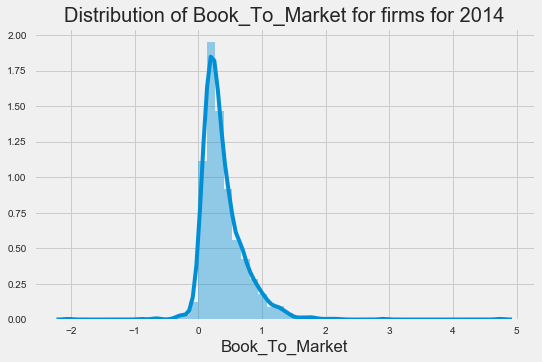

In [20]:
sns.distplot(df_clean["Book_To_Market"].dropna())
plt.title("Distribution of Book_To_Market for firms for 2014")

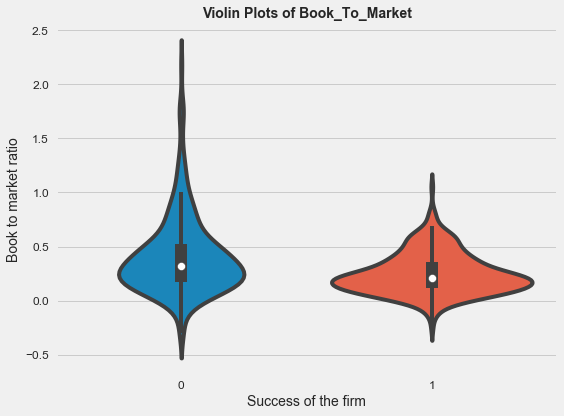

In [21]:
plt.figure(figsize=(8,6))
sns.violinplot(x='Winner', y='Book_To_Market', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("Book to market ratio", fontsize=14)
plt.title("Violin Plots of Book_To_Market", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

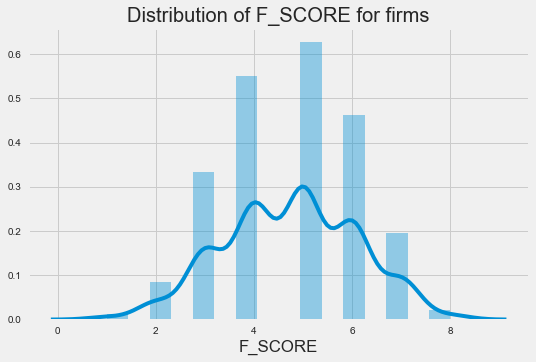

In [22]:
sns.distplot(df_clean["F_SCORE"].dropna())
plt.title("Distribution of F_SCORE for firms")

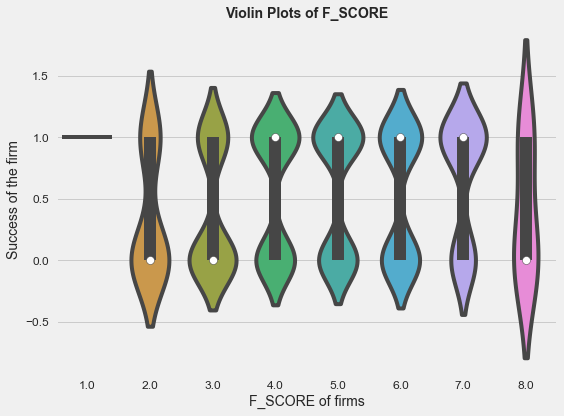

In [23]:
plt.figure(figsize=(8,6))
sns.violinplot(x='F_SCORE', y='Winner', data=df_clean.dropna())
plt.ylabel("Success of the firm", fontsize=14)
plt.xlabel("F_SCORE of firms", fontsize=14)
plt.title("Violin Plots of F_SCORE", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

([<matplotlib.axis.YTick at 0x1104a34d0>,
 <a list of 6 Text yticklabel objects>)

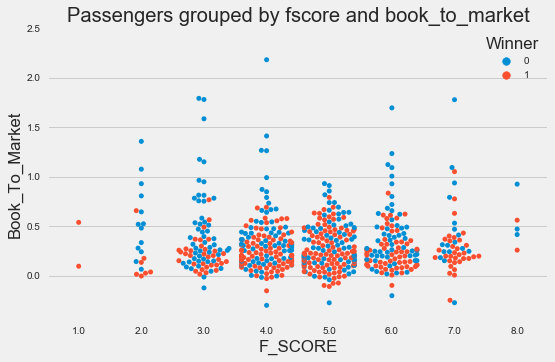

In [24]:
sns.swarmplot(x="F_SCORE", y="Book_To_Market", hue="Winner", data=df_clean.dropna())
plt.title('Passengers grouped by fscore and book_to_market')
plt.yticks(np.arange(0,3,.5))

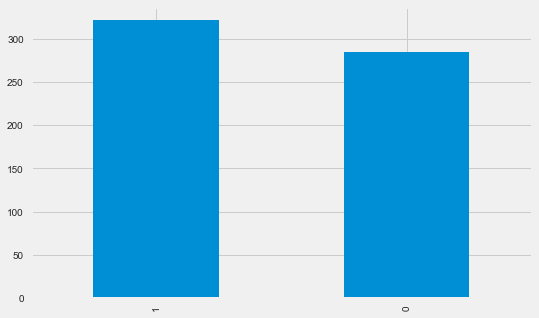

In [25]:
display(df_clean.dropna()['Winner'].value_counts().plot(kind='bar'))


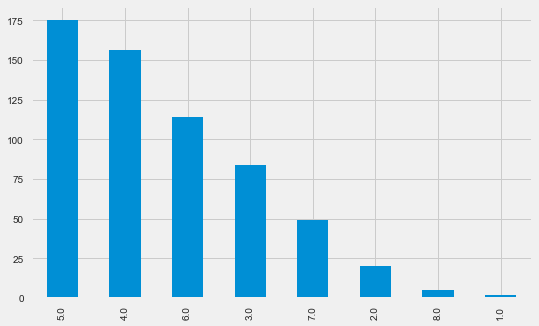

In [26]:
display(df_clean.dropna()['F_SCORE'].value_counts().plot(kind='bar'))

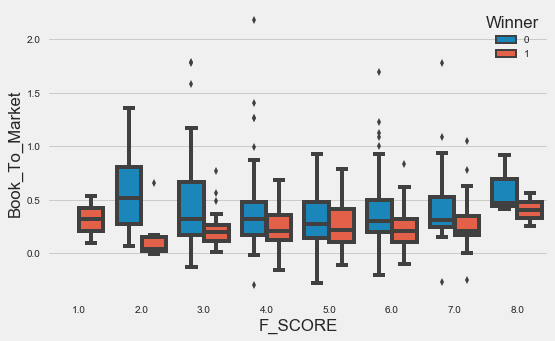

In [27]:
sns.boxplot(x="F_SCORE", y="Book_To_Market", hue="Winner", data=df_clean.dropna())

#### How does it look for individual contributors to f_score

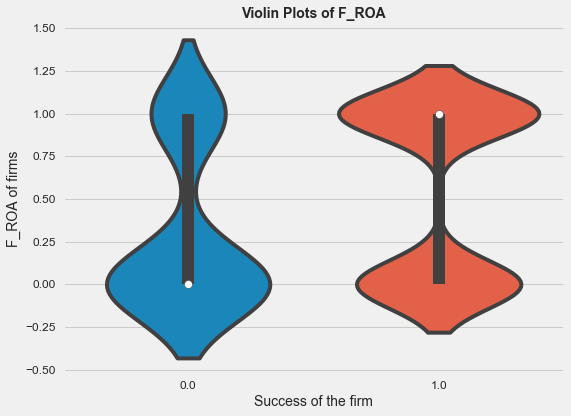

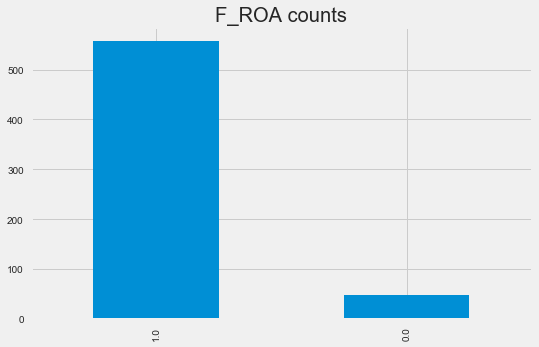

In [28]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_ROA', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_ROA of firms", fontsize=14)
plt.title("Violin Plots of F_ROA", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_ROA'].value_counts().plot(kind='bar', title='F_ROA counts'))

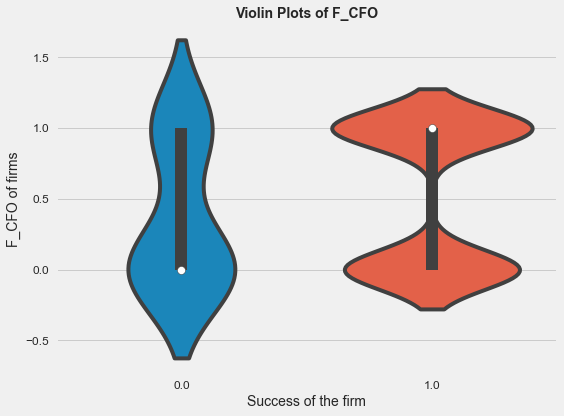

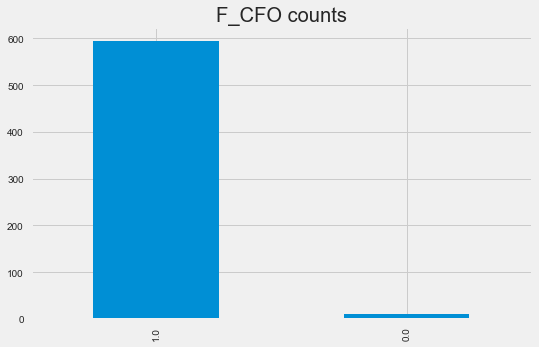

In [29]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_CFO', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_CFO of firms", fontsize=14)
plt.title("Violin Plots of F_CFO", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_CFO'].value_counts().plot(kind='bar', title='F_CFO counts'))

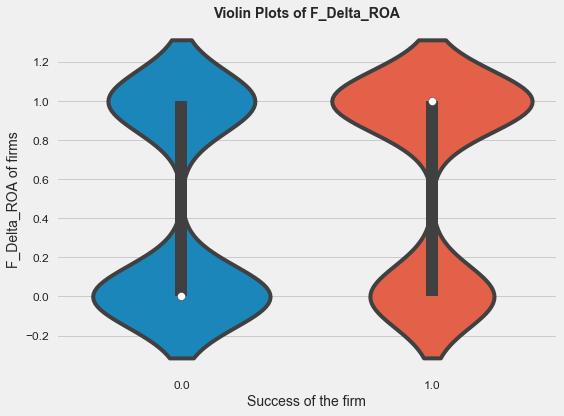

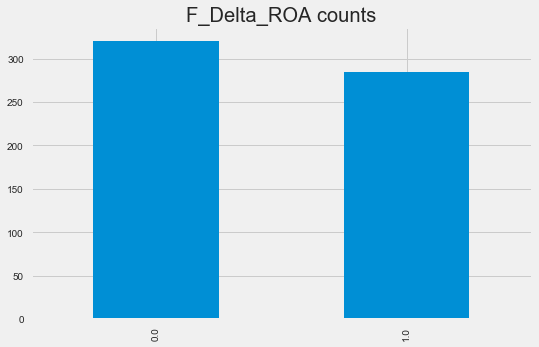

In [30]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Delta_ROA', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Delta_ROA of firms", fontsize=14)
plt.title("Violin Plots of F_Delta_ROA", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Delta_ROA'].value_counts().plot(kind='bar', title='F_Delta_ROA counts'))

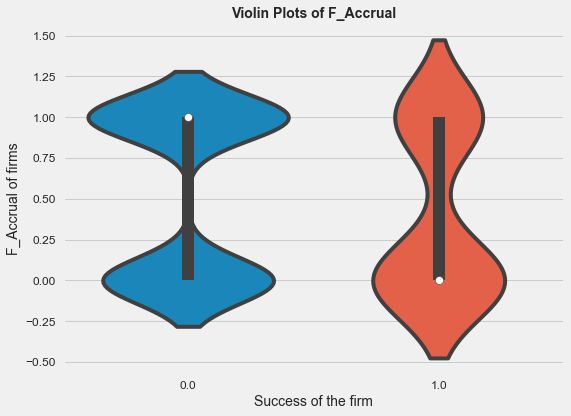

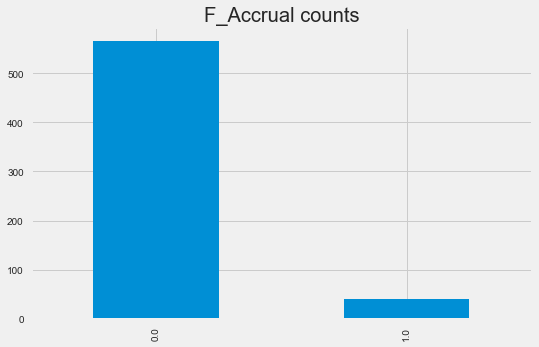

In [31]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Accrual', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Accrual of firms", fontsize=14)
plt.title("Violin Plots of F_Accrual", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Accrual'].value_counts().plot(kind='bar', title='F_Accrual counts'))

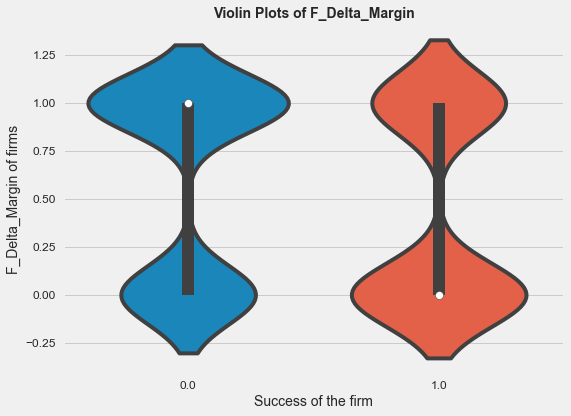

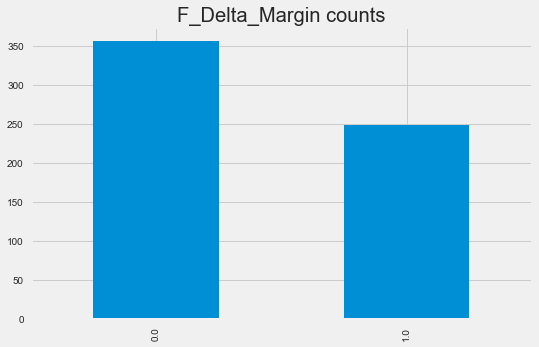

In [32]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Delta_Margin', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Delta_Margin of firms", fontsize=14)
plt.title("Violin Plots of F_Delta_Margin", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Delta_Margin'].value_counts().plot(kind='bar', title='F_Delta_Margin counts'))

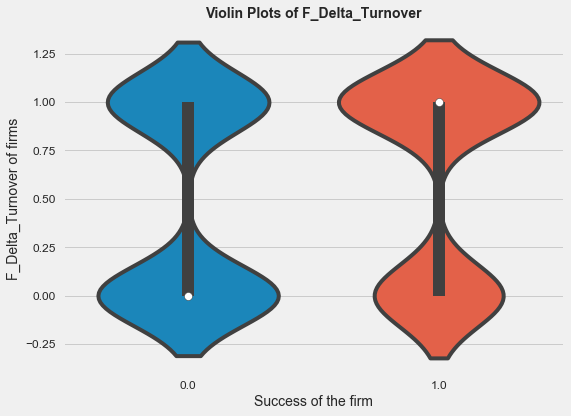

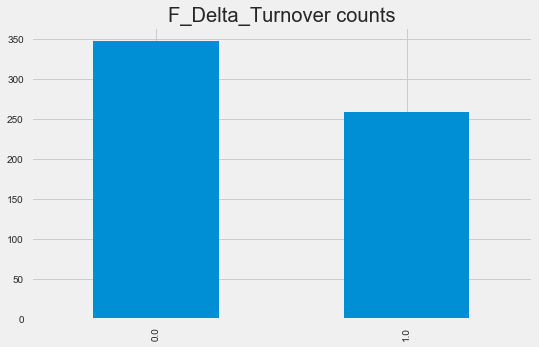

In [33]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Delta_Turnover', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Delta_Turnover of firms", fontsize=14)
plt.title("Violin Plots of F_Delta_Turnover", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Delta_Turnover'].value_counts().plot(kind='bar', title='F_Delta_Turnover counts'))


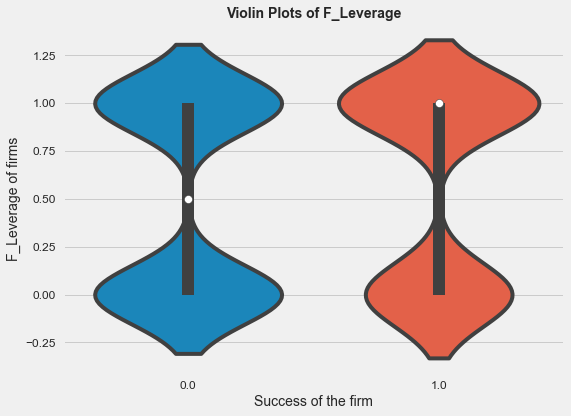

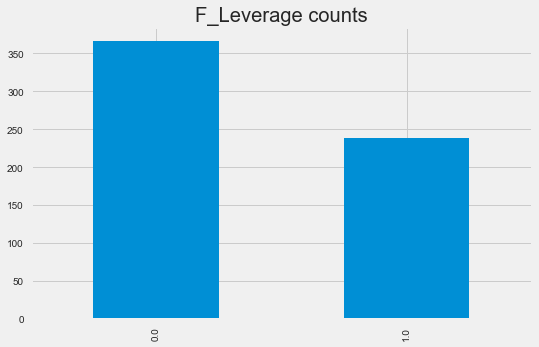

In [34]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Leverage', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Leverage of firms", fontsize=14)
plt.title("Violin Plots of F_Leverage", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Leverage'].value_counts().plot(kind='bar', title='F_Leverage counts'))


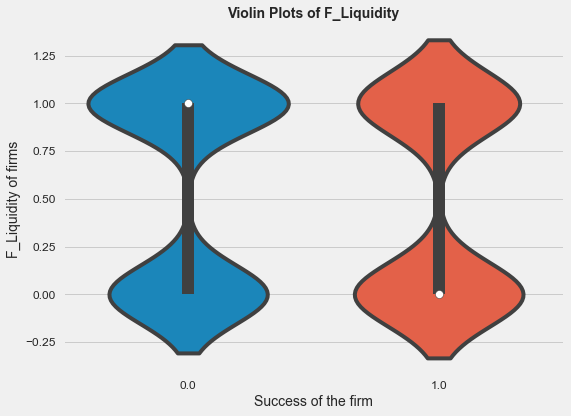

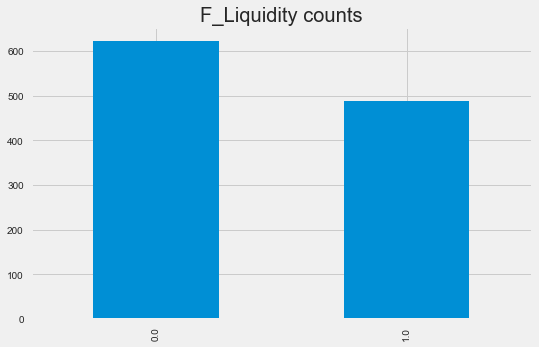

In [35]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Liquidity', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Liquidity of firms", fontsize=14)
plt.title("Violin Plots of F_Liquidity", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean['F_Liquidity'].value_counts().plot(kind='bar', title='F_Liquidity counts'))

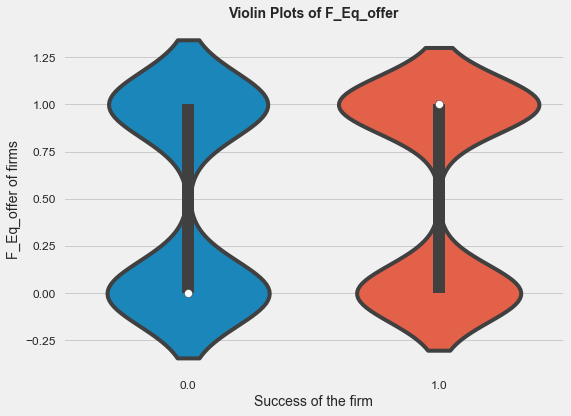

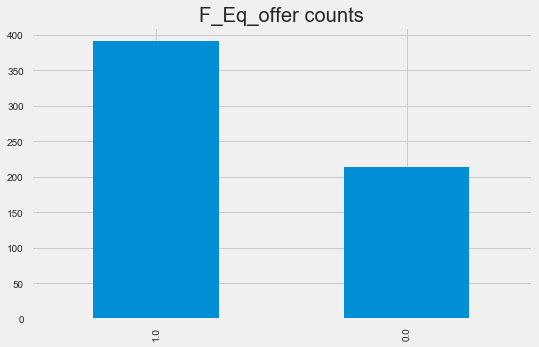

In [36]:
plt.figure(figsize=(8,6))
sns.violinplot(y='Winner', x='F_Eq_Offer', data=df_clean.dropna())
plt.xlabel("Success of the firm", fontsize=14)
plt.ylabel("F_Eq_offer of firms", fontsize=14)
plt.title("Violin Plots of F_Eq_offer", fontsize=14, weight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
display(df_clean.dropna()['F_Eq_Offer'].value_counts().plot(kind='bar', title='F_Eq_offer counts'))

### Modeling

#### We will use book_to_market filter to pick firms

In [37]:
features = ["F_ROA", "F_CFO", "F_Delta_ROA", "F_Accrual", "F_Delta_Margin", "F_Delta_Turnover", "F_Leverage", "F_Liquidity", "F_Eq_Offer", "F_SCORE"]


# ideally, I want to pick stocks > 1, however that results in a very small dataset
df_filtered = df_clean.copy().dropna()
df_filtered = df_filtered[df_filtered['Book_To_Market'] >= .75]

X = df_filtered[features]
y = df_filtered['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

display(X_train.info())
display(X_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2015-12-31 to 2014-12-31
Data columns (total 10 columns):
F_ROA               32 non-null float64
F_CFO               32 non-null float64
F_Delta_ROA         32 non-null float64
F_Accrual           32 non-null float64
F_Delta_Margin      32 non-null float64
F_Delta_Turnover    32 non-null float64
F_Leverage          32 non-null float64
F_Liquidity         32 non-null float64
F_Eq_Offer          32 non-null float64
F_SCORE             32 non-null float64
dtypes: float64(10)
memory usage: 2.8 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2015-12-31 to 2014-12-31
Data columns (total 10 columns):
F_ROA               14 non-null float64
F_CFO               14 non-null float64
F_Delta_ROA         14 non-null float64
F_Accrual           14 non-null float64
F_Delta_Margin      14 non-null float64
F_Delta_Turnover    14 non-null float64
F_Leverage          14 non-null float64
F_Liquidity         14 non-null float64
F_Eq_Offer          14 non-null float64
F_SCORE             14 non-null float64
dtypes: float64(10)
memory usage: 1.2 KB


None

#### Generic functions to try different classifications

In [38]:
from __future__ import division, print_function
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def plot_roc(name, ytest, y_score):
    fpr, tpr, threshold = metrics.roc_curve(ytest, y_score)

    plt.plot(fpr, tpr, label='ROC curve of {} (area = {:0.2f})'.format(name, metrics.roc_auc_score(ytest,y_score)));
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC curve of various models');
    plt.ylim(np.arange(0,1.2));

def fit_model(model, xtrain, ytrain):
    model.fit(xtrain,ytrain)
    return model
    
def eval_model(model, name, xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test):
    model = fit_model(model, xtrain, ytrain)
    y_pred = model.predict(xtest)
    
    y_score = model.predict_proba(xtest)[:,1]
    plot_roc(name, ytest, y_score);
    plt.legend();
    
    print ("------------------------------------------------")
    
    print ("Accuracy of {} model: {}".format(name, metrics.accuracy_score(ytest, y_pred)), end="\n\n")
    
    print ("Classification report for {} model".format(name), end="\n\n")
    print (metrics.classification_report(y_test, y_pred, target_names=['Winner', 'Loser']))
    
    print ("Confusion matrix for {} model".format(name), end="\n\n")
    conmat = metrics.confusion_matrix(y_test, y_pred)
    conmat = pd.DataFrame(conmat, index=['Winner', 'Loser'], columns=['Winner', 'Loser'])
    print (conmat, end="\n\n")
    
    return model

------------------------------------------------
Accuracy of KNN model: 0.857142857143

Classification report for KNN model

             precision    recall  f1-score   support

     Winner       0.86      1.00      0.92        12
      Loser       0.00      0.00      0.00         2

avg / total       0.73      0.86      0.79        14

Confusion matrix for KNN model

        Winner  Loser
Winner      12      0
Loser        2      0



/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abisundaram/Library/Python/2.7/lib/python/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


------------------------------------------------
Accuracy of Logistic Regression model: 0.857142857143

Classification report for Logistic Regression model

             precision    recall  f1-score   support

     Winner       0.86      1.00      0.92        12
      Loser       0.00      0.00      0.00         2

avg / total       0.73      0.86      0.79        14

Confusion matrix for Logistic Regression model

        Winner  Loser
Winner      12      0
Loser        2      0

------------------------------------------------
Accuracy of Decision Tree model: 0.5

Classification report for Decision Tree model

             precision    recall  f1-score   support

     Winner       0.78      0.58      0.67        12
      Loser       0.00      0.00      0.00         2

avg / total       0.67      0.50      0.57        14

Confusion matrix for Decision Tree model

        Winner  Loser
Winner       7      5
Loser        2      0

------------------------------------------------
Accura

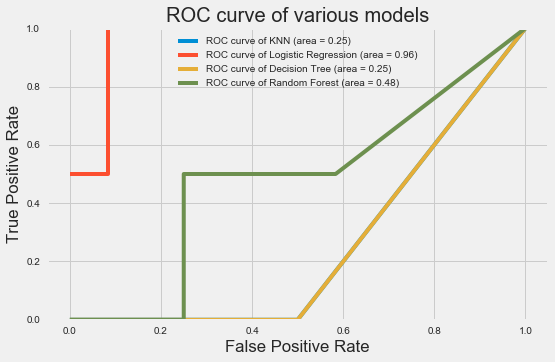

In [39]:
# Evaluate a K nearest neighbors model
model_kn = eval_model(KNeighborsClassifier(), "KNN", xtrain=X_train, 
           xtest=X_test, ytrain=y_train, ytest=y_test)


# Evaluate a Logistic Regression model
# I'm using the one with cross validation
model_lg = eval_model(LogisticRegressionCV(cv=5), "Logistic Regression", xtrain=X_train, 
           xtest=X_test, ytrain=y_train, ytest=y_test) 

# Evaluate a Decision Tree model
model_dt = eval_model(DecisionTreeClassifier(), "Decision Tree", xtrain=X_train, 
           xtest=X_test, ytrain=y_train, ytest=y_test)

# Evaluate a Random Forest model
model_rf = eval_model(RandomForestClassifier(), "Random Forest", xtrain=X_train, 
           xtest=X_test, ytrain=y_train, ytest=y_test)


#### What features look to be important from random forest

In [40]:
feature_importances = model_rf.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
display(features_df)

,Features,Importance Score
0,F_ROA,0.018039
1,F_CFO,0.157746
2,F_Delta_ROA,0.080798
3,F_Accrual,0.087537
4,F_Delta_Margin,0.049573
5,F_Delta_Turnover,0.071472
6,F_Leverage,0.086018
7,F_Liquidity,0.066895
8,F_Eq_Offer,0.092787
9,F_SCORE,0.189136


#### how does our decision tree look

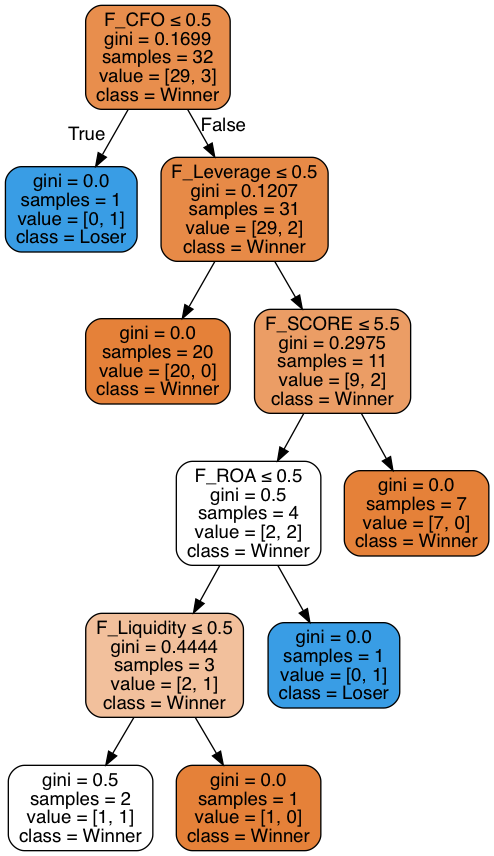

In [41]:
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_data = tree.export_graphviz(model_dt, out_file=None, 
                         feature_names=X.columns,  
                         class_names=["Winner", "Loser"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

### Conclusion

    F_SCORE based metrics show promise with the prediction of stocks, however, the analysis is inconclusive because of the limited useabe data points.
    - Using book_to_market ratio of > 1 (i.e., typical metric for undervalued firms), the data points are extremely limited
    - Relaxing the book_to_market ratio to be >= 0.75 yields about 50 data points, where the logistic regression is able to predict winners with about 85% accuracy
    - Relaxing the book_to_market ratio even further increases the data points, however, the classification accuracy goes down 